### Image processing

In [1]:
import imageio
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    #reading image
    path=str(path).strip('b').strip("'")
    image=imageio.imread(path)
    if np.sum(np.isnan(image))>0:
        #print(str(np.sum(np.isnan(image)))+"nans found")
        #taking the mean of the image, per channel
        mean=np.nanmean(image,axis=(0,1))
        #replacing NaN with per channel mean
        replacement=np.isnan(image)*mean
        image[np.isnan(image)]=replacement[np.isnan(image)]  
        #print(str(np.sum(np.isnan(image)))+"nans found")
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
        image=image/255
    return image

In [3]:
image_files = [f for f in os.listdir("../GEE_Images")]

len(image_files)

51782

In [68]:
""" run when mp10.txt not present
image_info=[]
for image in image_files:
    name,_=os.path.splitext(image)
    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])
df=pd.read_csv('processed_data.csv')
mp10=[]
for info in image_info:
    mp10.append(df[(df['station']==info[0]) & (df['Date']==info[1])]['mp10'].values[0])
    """

In [5]:
with open('mp10.txt', 'r') as f:
  mp10 = [float(line.strip()) for line in f]

In [17]:
for a in range(len(image_files)):
    image_files[a]="../GEE_Images/"+image_files[a]
train_image_files, test_image_files, train_mp10, test_mp10 = train_test_split(
    image_files, mp10, test_size=0.2, random_state=42)


### Model using one NN 224,224,6 
#### Generator for 224,224,6

In [6]:
def data_generator(image_files, lista):
    i=0
    for file in image_files:
        mp10=tf.convert_to_tensor(lista[i],dtype=tf.float32)
        image = preprocess_imagery(file)
        image=tf.convert_to_tensor(image, dtype=tf.float32)
        yield image, mp10

# Crear el Dataset
def create_dataset(image_files,lista, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, lista],
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset=dataset.repeat()
    return dataset

In [11]:
""" dont run, alternative to loading images
for file in image_files:
    image = preprocess_imagery("../GEE_Images/"+file)
    images.append(tf.convert_to_tensor(image, dtype=tf.float32))
images=np.array(images)
mp10=np.array(mp10)
X_train, X_test, y_train, y_test = train_test_split(images, mp10, test_size=0.2, random_state=42)
"""

/tmp/ipykernel_13918/850835770.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
2024-05-21 23:51:55.370017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_13918/850835770.py:12: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Capa de pooling
    model.add(layers.AveragePooling2D((2, 2)))

    # Otras capas convolucionales y de pooling para aumentar la profundidad
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    # Aplanar los datos para alimentar la capa densa
    model.add(layers.Flatten())

    # Capas densas para la parte final de la red
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización con dropout
    model.add(layers.Dense(1, activation='linear'))  # Capa de salida con activación lineal para valores float

    return model

# Crear el modelo
input_shape = (224, 224, 6)
model = build_model(input_shape)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()


c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,473 (169.36 MB)

 Trainable params: 44,397,473 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Configuración de entrenamiento
batch_size = 500
epochs = 15
full_history=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size

for epoch in range(epochs):
    print("Epoch: ",epoch+1)
    epoch_history = {'loss': [], 'mae': []}
    for part in range(num_parts):
        start = part * batch_size
        end = (part + 1) * batch_size
        image_files_part = train_image_files[start:end]
        mp10_part = mp10[start:end]
        
        dataset = create_dataset(image_files_part, mp10_part, batch_size)
        
        # Entrenar el modelo con la parte actual del conjunto de datos
        history=model.fit(dataset, epochs=1,batch_size=50,steps_per_epoch=batch_size//50)

        epoch_history['loss'].append(history.history['loss'][0])
        epoch_history['mae'].append(history.history['mae'][0])
        print('Part: ',part+1)
        print('Loss: ',history.history['loss'][0])
        print('MAE: ',history.history['mae'][0])
    full_history.append({
        'epoch': epoch + 1,
        'loss': np.mean(epoch_history['loss']),
        'mae': np.mean(epoch_history['mae'])
    })
    print('Epoch Loss: ',np.mean(epoch_history['loss']))
    print('Epoch MAE: ',np.mean(epoch_history['mae']))
        
# Si quedan imágenes que no llenan un batch completo al final
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    
    dataset = create_dataset(image_files_part, mp10_part, batch_size)
    history = model.fit(dataset, epochs=1,batch_size=50)
    full_history.append({
        'epoch': epochs,
        'loss': history.history['loss'][0],
        'mae': history.history['mae'][0]
    })

Part: 1, Epoch: 1


C:\Users\benja\AppData\Local\Temp\ipykernel_20796\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


In [ ]:
test_dataset = create_dataset(test_image_files, test_mp10, df, batch_size)
model.evaluate(test_dataset)

In [15]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=16)


2024-05-22 00:02:19.920084: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1541406720 exceeds 10% of free system memory.


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 604ms/step - accuracy: 0.0000e+00 - loss: 826671104.0000 - mae: 7781.1650 - val_accuracy: 0.0031 - val_loss: 2745.6108 - val_mae: 43.5256
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 598ms/step - accuracy: 0.0000e+00 - loss: 2389.3083 - mae: 38.9321 - val_accuracy: 0.0031 - val_loss: 1868.4949 - val_mae: 32.4535
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 608ms/step - accuracy: 0.0000e+00 - loss: 1946.2864 - mae: 33.3932 - val_accuracy: 0.0031 - val_loss: 1801.4866 - val_mae: 31.5512
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 630ms/step - accuracy: 0.0000e+00 - loss: 1924.0051 - mae: 31.6385 - val_accuracy: 0.0031 - val_loss: 1884.2473 - val_mae: 33.3156
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.0000e+00 - loss: 1748.4365 - mae: 31.2740 - val_accuracy: 0.0031 - val_loss: 1792.4309 - val_mae: 31.0692
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.0000e+00 - loss: 1612.0415 - mae: 30.6824 - val_accuracy: 0.0

In [16]:
test=X_test[0]
test=np.expand_dims(test, axis=0)
np.shape(test)

(1, 224, 224, 6)

In [17]:
prediction=model.predict(test)
print(prediction,y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[62.967506]] 64.6875


In [18]:
# Evaluamos el modelo
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.0000e+00 - loss: 1871.8628 - mae: 29.4749
Test Loss: [2024.589111328125, 31.186094284057617, 0.0]


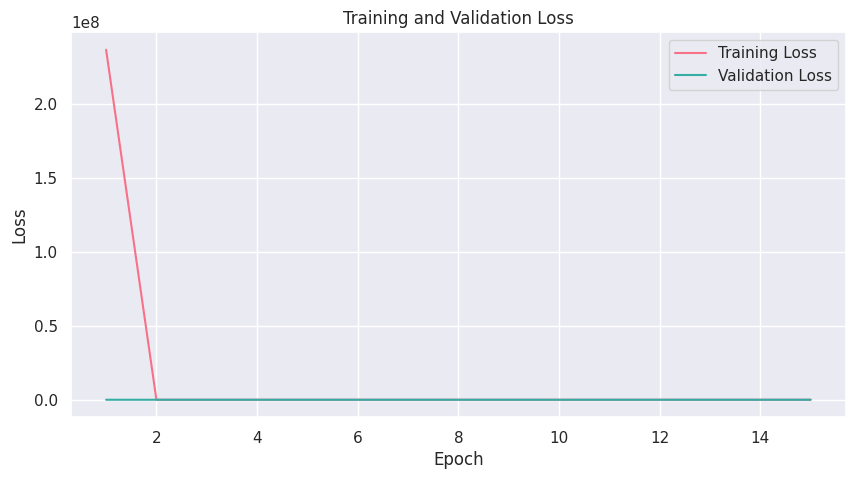

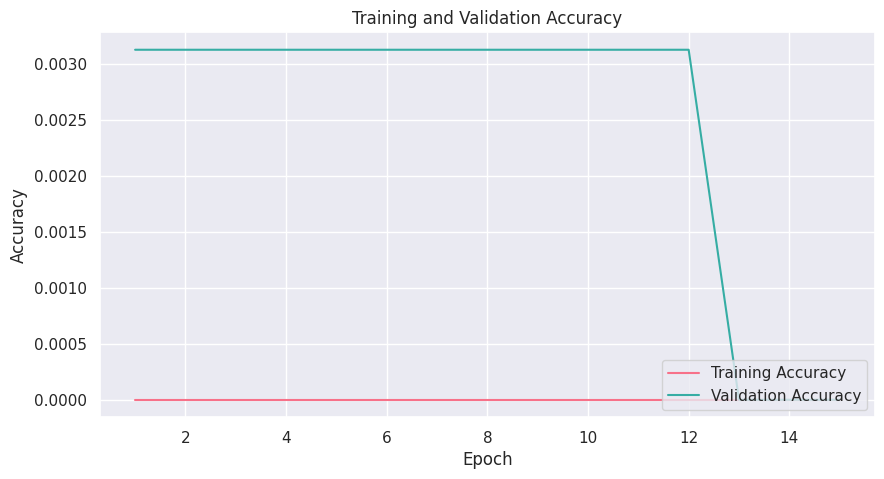

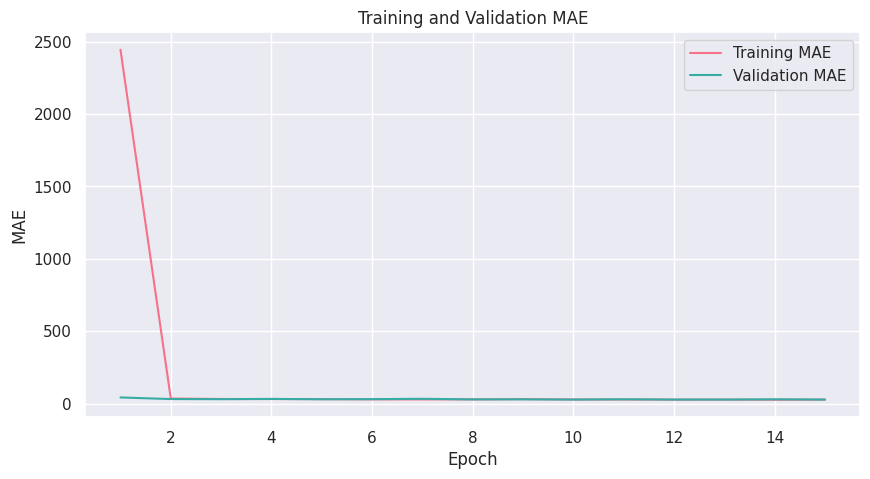

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Obtener las métricas de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear un DataFrame para Seaborn
epochs = range(1, len(train_loss) + 1)
history_df = pd.DataFrame({'Epoch': epochs,
                           'Training Loss': train_loss,
                           'Validation Loss': val_loss,
                           'Training Accuracy': train_acc,
                           'Validation Accuracy': val_acc,
                           'Training MAE': train_mae,
                           'Validation MAE': val_mae})

# Graficar las pérdidas
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Loss', 'Validation Loss']),
             palette="husl")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Graficar la precisión
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Accuracy', 'Validation Accuracy']),
             palette="husl")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Graficar el MAE
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training MAE', 'Validation MAE']),
             palette="husl")
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()


### For 6 NN with 224,224

In [10]:

def separar_imagen(imagen):
    """
    Separa una imagen con dimensiones (224, 224, 6) en 6 imágenes con dimensiones (224, 224, 1).

    Args:
    imagen (numpy.ndarray): Imagen original con dimensiones (224, 224, 6).

    Returns:
    tuple: Una tupla con 6 numpy.ndarrays, cada uno con dimensiones (224, 224, 1).
    """
    # Verificar que la imagen tenga las dimensiones correctas
    assert imagen.shape == (224, 224, 6), "La imagen debe tener dimensiones (224, 224, 6)"
    
    # Separar la imagen en 6 partes
    imagenes_separadas = tuple(imagen[:, :, i][:, :, np.newaxis] for i in range(6))
    
    return imagenes_separadas

In [16]:
def data_generator_layer(image_files, lista,layer):
    i=0
    for file in image_files:
        mp10=tf.convert_to_tensor(lista[i],dtype=tf.float32)
        image = preprocess_imagery(file)
        image= separar_imagen(image)[layer]
        image=tf.convert_to_tensor(image, dtype=tf.float32)
        yield image, mp10

# Crear el Dataset
def create_dataset_layer(image_files,lista,layer, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator_layer,
        args=[image_files, lista,layer],
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset=dataset.repeat()
    return dataset

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout

def build_model_layer():
    # Crear el modelo secuencial
    model = Sequential()

    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Segunda capa de convolución 2D
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Tercera capa de convolución 2D
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Cuarta capa de convolución 2D
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Aplanar la salida de la capa de pooling
    model.add(Flatten())

    # Añadir una capa densa
    model.add(Dense(units=128, activation='relu'))

    # Añadir la capa de Dropout
    model.add(Dropout(rate=0.5))

    # Añadir la capa de salida con activación lineal
    model.add(Dense(units=1, activation='linear'))
    return model
model=build_model_layer()
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Configuración de entrenamiento
batch_size = 500
epochs = 10
full_history=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,0, batch_size)
    history=model.fit(dataset,epochs=epochs,batch_size=50)
    full_history.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,0, batch_size)
    history=model.fit(dataset,epochs=epochs,batch_size=50)
    full_history.append([history.history['loss'],history.history['mae']])